## Import packages

In [41]:
import time
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import caffeine
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy.stats import percentileofscore
from numpy.typing import ArrayLike
from typing import Dict

# Read Data & Preprocess

In [2]:
df = pd.read_csv('./data/Day-ahead_Prices_60min.csv')

In [3]:
# Rename columns for simplicity, drop missing/invariant columns
df = df.rename(columns={'MTU (CET/CEST)': "dt", 'Day-ahead Price [EUR/MWh]': 'price'})
df = df.iloc[:, :2]  # other two columns were invariant or missing

#### Convert `MTU (CET/CEST)` to start of 60 min contract

In [4]:
df['dt'] = df['dt'].apply(lambda x: ''.join(x.split(' - ')[0])) # take first time listed
df['dt'] = pd.to_datetime(df['dt'], format='%d.%m.%Y %H:%M')

#### Engineer Time Features: Date, Month, Day of Month (dom), Day of Week (dow), Hour of Day

In [5]:
df['date'] = df['dt'].dt.date
df['hour'] = df['dt'].dt.hour
df['month'] = df['dt'].dt.month
df['dow'] = df['dt'].dt.dayofweek  # numeric day, 0 is Monday, 6 is Sunday
df['dom'] = df['date'].astype(str).apply(lambda x: int(x.split('-')[-1]))  # date of month
df['doy'] = df['dt'].dt.day_of_year  # numeric day of year

#### Interpolate prices for missing values

**Below we see that a small fraction (1 observation) of day-ahead price is missing, which will cause modeling problems later. We therefore linearly interpolate these prices by taking the mean of the surrounding values**

In [6]:
print(df.isnull().mean())
print("\nNumber of missings:" , df['price'].isnull().sum())

dt       0.00000
price    0.00023
date     0.00000
hour     0.00000
month    0.00000
dow      0.00000
dom      0.00000
doy      0.00000
dtype: float64

Number of missings: 1


In [7]:
print("Before: \n", df.iloc[2041:2044, 1])
df['price'] = df['price'].fillna(df.iloc[2041:2044, 1].mean())
print("\n\nAfter: \n", df.iloc[2041:2044, 1])

Before: 
 2041    221.93
2042       NaN
2043    214.02
Name: price, dtype: float64


After: 
 2041    221.930
2042    217.975
2043    214.020
Name: price, dtype: float64


#### Final dataset

In [8]:
df

,dt,price,date,hour,month,dow,dom,doy
0,2022-01-01 00:00:00,50.05,2022-01-01,0,1,5,1,1
1,2022-01-01 01:00:00,41.33,2022-01-01,1,1,5,1,1
2,2022-01-01 02:00:00,43.22,2022-01-01,2,1,5,1,1
3,2022-01-01 03:00:00,45.46,2022-01-01,3,1,5,1,1
4,2022-01-01 04:00:00,37.67,2022-01-01,4,1,5,1,1
...,...,...,...,...,...,...,...,...
4339,2022-06-30 19:00:00,479.00,2022-06-30,19,6,3,30,181
4340,2022-06-30 20:00:00,450.00,2022-06-30,20,6,3,30,181
4341,2022-06-30 21:00:00,394.21,2022-06-30,21,6,3,30,181
4342,2022-06-30 22:00:00,355.17,2022-06-30,22,6,3,30,181


# Exploratory Data Analysis (EDA)

In [9]:
df.shape

(4344, 8)

In [10]:
print(df['dt'].min())
print(df['dt'].max())

2022-01-01 00:00:00
2022-06-30 23:00:00


In [11]:
df['price'].describe()

count    4344.000000
mean      185.809573
std        90.647697
min       -19.040000
25%       122.155000
50%       189.005000
75%       232.927500
max       700.000000
Name: price, dtype: float64

In [12]:
df[df['price']<0].shape

(38, 8)

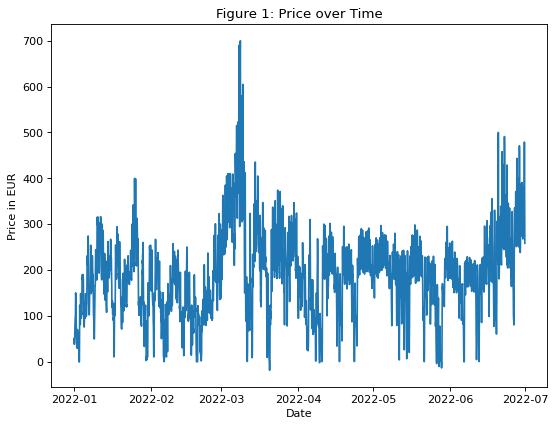

In [15]:
figure(figsize=(8, 6), dpi=80)
sns.lineplot(df, x='dt', y='price')
plt.ylabel('Price in EUR')
plt.xlabel('Date')
plt.title('Figure 1: Price over Time')
plt.show()

# Question 1.1

We start by calculating the percentile rank, a common distributional statistic, of each price grouped by date using the function `series_percentile`. An intutitive explanation of percentile rank is e.g. 80% means that 80% of the scores in a series/array are below the given score. 

Using percentile rank conditions out price shifts over time such as what we see in `Figure 1` above. This allows us to compare prices *relative* to the other prices for a given day, rather than compare them absolutely across time. Percentile rank is also more robust to outliers than mean-based scores (e.g. [standardized score](https://en.wikipedia.org/wiki/Standard_score))

In [16]:
def series_percentile(series: pd.Series) -> pd.Series:
    """
    Calculates the average percentage ranking of a pd.Series. In case of multiple matches, average 
        the percentage rankings of all matching scores.
    :param series: pd.Series, a single day's price data
    :return: pd.Series
    """
    return pd.Series([percentileofscore(series, a, 'rank') for a in series])

In [17]:
perc = df.groupby('date')['price'].apply(series_percentile).reset_index()
perc = perc.rename(columns={'price': 'percentile'})
df = pd.concat([df, perc['percentile']], axis=1)

In [18]:
df

,dt,price,date,hour,month,dow,dom,doy,percentile
0,2022-01-01 00:00:00,50.05,2022-01-01,0,1,5,1,1,37.500000
1,2022-01-01 01:00:00,41.33,2022-01-01,1,1,5,1,1,16.666667
2,2022-01-01 02:00:00,43.22,2022-01-01,2,1,5,1,1,20.833333
3,2022-01-01 03:00:00,45.46,2022-01-01,3,1,5,1,1,29.166667
4,2022-01-01 04:00:00,37.67,2022-01-01,4,1,5,1,1,4.166667
...,...,...,...,...,...,...,...,...,...
4339,2022-06-30 19:00:00,479.00,2022-06-30,19,6,3,30,181,100.000000
4340,2022-06-30 20:00:00,450.00,2022-06-30,20,6,3,30,181,95.833333
4341,2022-06-30 21:00:00,394.21,2022-06-30,21,6,3,30,181,87.500000
4342,2022-06-30 22:00:00,355.17,2022-06-30,22,6,3,30,181,70.833333


Next, we calculate some measures of central tendency (i.e. the mean and median) by hour of day. This tells us typically what times of day energy prices are highest and lowest. 

In [19]:
hourly_mean = df.groupby('hour')['percentile'].mean()
hourly_median = df.groupby('hour')['percentile'].median()

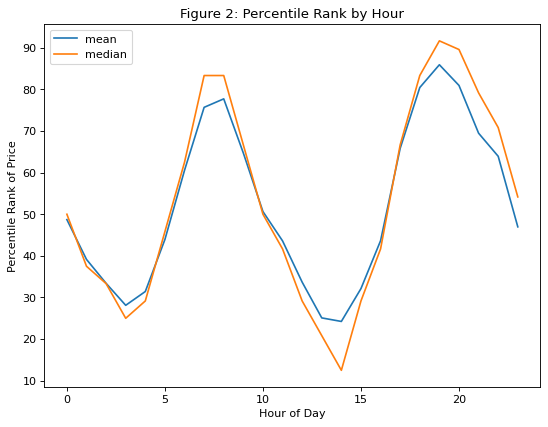

In [20]:
figure(figsize=(8, 6), dpi=80)
sns.lineplot(hourly_mean, label='mean')
sns.lineplot(hourly_median, label='median')
plt.ylabel('Percentile Rank of Price')
plt.xlabel('Hour of Day')
plt.title('Figure 2: Percentile Rank by Hour')
plt.show()

### Answer

According to `Figure 2`, **energy prices are typically *lowest* between 1h and 5h and again between 11h and 15h, meaning that profits could be maximized by *charging* during these off-peak times.**

Conversely, **energy prices are typically *highest* from 6h-10h and 16h-22h, meaning profits could be maximized by *discharging* during these peak times.**

# Question 1.2

## 1.2.1 Algorithm setup

Predicting future energy costs in order to optimize charge and discharge times is a univariate time series forecasting problem. Since we're not allowed to use future information (as in real life), the following pseudocode explains how we'll iteratively forecast energy prices and select the optimal times of the day to charge and discharge.

Variables
- Let `t` represent the numeric calendar day of the year (all hours for that day)
- Let `t`+1 represent the day we forecast (all hours for that day)
- Let `j` represent the number of days to include in the rolling window


Algorithm
- Initialize `t` as 60 (i.e. 1 March 2022)
- Set `j` as 60 for all T
- Initialize empty dataframe, `results`, to store results
- For each `t` in df.day_of_year.unique()[`t`:-1]:
    - `training_data` = df[(df.day_of_year <= `t`) & (df.day_of_year > (`t`-`j`))]
    - `test_data` = df[df.day_of_year == `t`+1]
    - train model on `training_data`
    - forecast prices in `t+1` using `train_data`
    - get argmax[:2], argmin[:2] of forecast prices from train_data to determine optimal times to discharge and charge, respectively  **TODO**
    - concatenate argmax[:2], argmin[:2] to `results`   **TODO**
    - compare results to `test_data`  **TODO**


Setting `j` at 60 means we use the first 60 days' worth of data as our training set. Because we lose the first 60 days, we are only able to generate price forecasts between 2. March 2022 - 30. June 2022 inclusive. However, we need a sufficient `j` in order to accurately estimate future prices.

Alternatively, we could use a smaller `j`, e.g. 30 days. Auxiliary analyses suggested... **TODO** With additional time, it would be worthwhile to examine the speed-performance trade-off of this restriction.

But why limit the training set via `j` to begin? Because we're estimating the model repeatedly via a loop, this restriction drastically speeds up algorithm completion, otherwise the size of `training_set` would grow with each `t`. With additional time, it would be worthwhile to examine the speed-performance trade-off of this restriction.

## 1.2.2 Seasonal ARIMA model

One of the most common time series models is an [Autoregressive integrated moving average (ARIMA)](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) model. The basic ARIMA model comprises 3 components: 
- Autoregressive (AR) component, which denotes the model contains lagged parameters of the endogenous variable
- Integrated (I) component, which denotes the data has been transformed with one or more differences of previous values
- Moving average (MA) component, which denotes the regression error is a linear combination of contemporary and various lagged errors

This basic model is typically written as ARIMA(p, d, q), where the parameters represent:
- `p` - number of time lags of the autoregressive model (AR)
- `d` - number of differences (I)
- `q` - order of moving average terms (MA)

**One of the limitations of the basic ARIMA model, however, is that it cannot easily handle seasonality in the data. Daily fluctuations in energy prices can be viewed as a form of *seasonality*; thus, we use a modified form of this model called a seasonal ARIMA model**. 

The parameters are ARIMA(p, d, q)(P, D, Q)<sub>m </sub> where:
- `p`, `d`, `q` - same definition as above
- `P` - seasonal autoregressive order
- `D` - seasonal differnce order
- `Q` - seasonal moving average order
- `m` - number of timesteps for a single seasonal period


## 1.2.3 Finding the right parameter values

Because we iteratively estimate the model, it's important to automatically select optimal parameter values. We use the Python package `pmdarima` whose `auto_arima` method automatically finds the optimal parameters using a step-wise algorithm.

**The only parameter that this method cannot automatically induced is `m`. Auxiliary analyses suggested `m` = 12 provided satisfactory performance, so we use this value in the model**. In a real-world scenario it would be worth a more in-depth analysis using various values of `m` using e.g. a grid-search algorithm.

## 1.2.4 Results in the first iteration

In [21]:
# Initialize first time period
t = 60
j = 60
columns = ['dt', 'price']  # restrict to necessary columns
training_data = pd.Series(df[(df['doy'] <= t) & (df['doy'] > (t-j))][columns].set_index("dt")['price'])
test_data = pd.Series(df[df['doy'] == t+1][columns].set_index("dt")['price'])

In [ ]:
print(training_data.head())
print(test_data.head())

dt
2022-01-01 00:00:00    50.05
2022-01-01 01:00:00    41.33
2022-01-01 02:00:00    43.22
2022-01-01 03:00:00    45.46
2022-01-01 04:00:00    37.67
Name: price, dtype: float64
dt
2022-03-02 00:00:00    251.04
2022-03-02 01:00:00    248.43
2022-03-02 02:00:00    242.06
2022-03-02 03:00:00    233.14
2022-03-02 04:00:00    233.62
Name: price, dtype: float64


In [45]:
training_data.tail()

dt
2022-03-01 19:00:00    354.11
2022-03-01 20:00:00    315.87
2022-03-01 21:00:00    286.00
2022-03-01 22:00:00    266.94
2022-03-01 23:00:00    245.47
Name: price, dtype: float64

In [23]:
start = time.time()

m = 24 # number of observations per "cycle", see https://robjhyndman.com/hyndsight/seasonal-periods/

# We precalculate these to speed up training below
d = pm.arima.ndiffs(training_data)  # Estimate ARIMA differencing term, `d`
D = pm.arima.nsdiffs(training_data, max_D=5, m=m)  # Estimate the seasonal differencing term, `D`

model = pm.auto_arima(training_data,
                      start_p=1, max_p=48, 
                      start_q=1, max_q=48,
                      max_P=3, max_Q=3,
                      d=d, D=D, m=m,
                      method='nm', maxiter=20)  # note - params on this line speed up model convergence

print(f"Total time: {round(time.time() - start, 2)} seconds.")

Total time: 142.18 seconds.


In [24]:
print(model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                 1440
Model:             SARIMAX(1, 1, 0)x(2, 0, [1, 2], 24)   Log Likelihood               -5986.595
Date:                                 Wed, 03 May 2023   AIC                          11985.191
Time:                                         11:02:20   BIC                          12016.821
Sample:                                     01-01-2022   HQIC                         11996.998
                                          - 03-01-2022                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3627      0.020     18.048      0.000       0.323       0

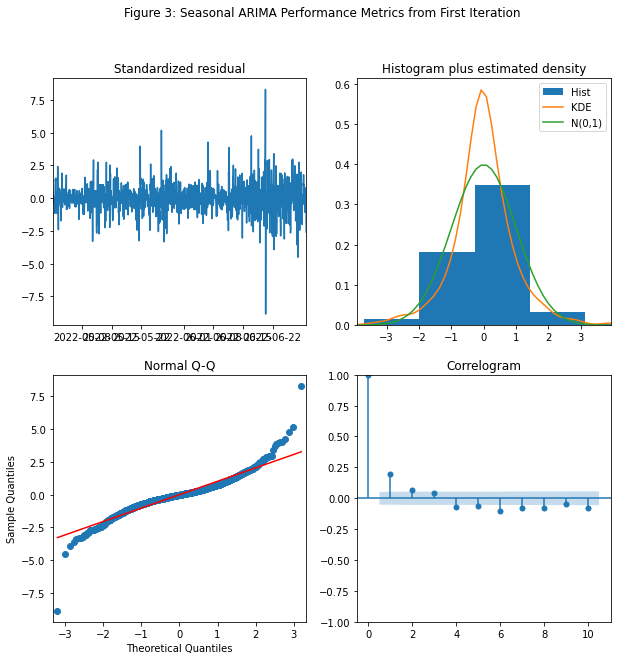

In [83]:
model.plot_diagnostics(figsize=(10,10))
plt.suptitle('Figure 3: Seasonal ARIMA Performance Metrics from First Iteration')
plt.show()

The plot diagnostics above indicate a relatively good forecasting fit.

- "Standardized residuals" - the residual errors seem to fluctuate around a mean of zero. There, however, seems to be **some evidence of lingering heteroskedasticity**. While this does not affect our forecasts, it does potentally affect the standard errors of our coefficients

- "Histogram plus estimated density" - We see some **evidence of positive kurtosis (leptokurtic)** in the standardized residuals (the orange kernel density plot and histogram) relative to the normal distribution (green line). Negative kurtisis is evident by the "light tails" of the distribution. This suggests there are more outliers relative to a normal distribution, since the tails of this distribution more slowly asymptotically approach zero than slowly than a standard Gaussian distribution. **This suggests our model may do less well at predicting extreme values**

- "Normal Q-Q" - we see again evidence of positive kurtosis as the tails drift more strongly from the red line, i.e. the expected distribution of normal residuals

- "Correlogram" - aka autocorrelation function (ACF) plot shows the residuals are not autocorrelated.  

In [26]:
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)

In [27]:
train_periods = 48
train = training_data[-train_periods:].reset_index().copy()
train['countdown'] = -((train['dt'].max() - train['dt']) / np.timedelta64(1, 'h')).astype(int)

test = test_data.reset_index().copy()
test['countdown'] = ((test['dt'] - test['dt'].min()) / np.timedelta64(1, 'h')).astype(int)

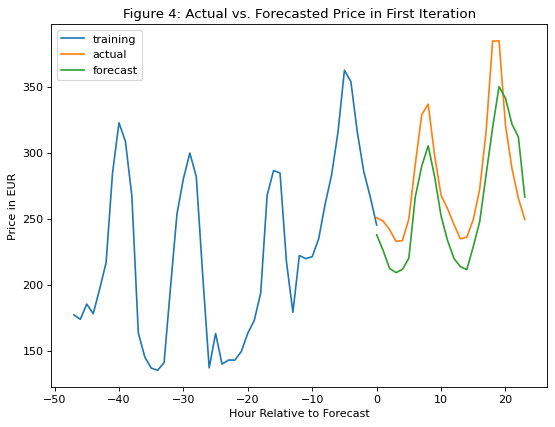

In [84]:
figure(figsize=(8, 6), dpi=80)
plt.plot(train['countdown'], train['price'], label='training')
plt.plot(test['countdown'], test['price'], label='actual')
plt.plot(test['countdown'], fc, label='forecast')
plt.xlabel('Hour Relative to Forecast')
plt.ylabel('Price in EUR')
plt.legend()
plt.title("Figure 4: Actual vs. Forecasted Price in First Iteration")
plt.show()

### 1.2.4.1 Accuracy metrics in the first iteration

In [42]:
def forecast_accuracy(forecast: ArrayLike, actual: ArrayLike) -> Dict:
    """
    Calculates common performance metrics of a forecast relative to the actual values.
    :param forecast: ArrayLike, vector of floating point predictions for each time point
    :param actual: ArrayLike, vector of floating point actual values for each time point
    :return: dictionary of 6 elements:
        "mape" : mean absolute percentage error, i.e. average of the absolute percentage difference
        "mse": mean squared error, i.e. average of the squared difference
        "mae": mean absolute error, i.e. average of the absolute difference
        "rmse": root mean squared error, i.e. square root of the mean squared error, measuring std of residuals
        "corr": Pearson product-moment correlation coefficients
    """
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))  # MAPE
    mse = np.mean((forecast - actual)**2)  # MSE
    mae = np.mean(np.abs(forecast - actual))  # MAE
    rmse = np.mean((forecast - actual) ** 2) ** .5  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]  # corr
    return ({'mape': mape, 'mse': mse, 'mae': mae,
             'rmse': rmse, 'corr': corr})


In [43]:
forecast_accuracy(fc, test_data)

{'mape': 0.04985810224575785,
 'mse': 363.95505760697824,
 'mae': 14.76856433612774,
 'rmse': 19.077606181252882,
 'corr': 0.9491557786464747}

Without going into great detail, the forecast metrics above tell us the model does a good job in predicting the next 24 hours of the time series in the first iteration. The mean absolute percentage error of 0.05 tells us that we're about 95% accurate in predicting the next 24 hours. On average, our forecasts miss the true price by about 14.8 EUR in absolute terms according to the mean absolute error.

## 1.2.5 Run the full algorithm

In [ ]:
t = 60
j = 60
columns = ['dt', 'price']  # restrict to necessary columns
m = 24

results = pd.DataFrame()
start = time.time()
for count, t in enumerate(df['doy'].unique()[t:-1]):

    training_data = pd.Series(df[(df['doy'] <= t) & (df['doy'] > (t-j))][columns].set_index("dt")['price'])
    test_data = pd.Series(df[df['doy'] == t+1][columns].set_index("dt")['price'])

    # We precalculate these to speed up training below
    d = pm.arima.ndiffs(training_data)  # Estimate ARIMA differencing term, `d`
    D = pm.arima.nsdiffs(training_data, max_D=5, m=m)  # Estimate the seasonal differencing term, `D`

    model = pm.auto_arima(training_data,
                          start_p=1, max_p=48, 
                          start_q=1, max_q=48,
                          max_P=3, max_Q=3,
                          d=d, D=D, m=m,
                          suppress_warnings=True,
                          method='nm', maxiter=20)  # note - params on this line speed up model convergence
    
    fc = model.predict(n_periods=24, return_conf_int=False)
    
    iteration_result = pd.DataFrame([test_data.index, test_data.values, fc]).T.rename(columns={0: 'dt', 1: 'actual', 2: 'forecasted'})
    
    results = pd.concat([results, iteration_result], axis=0)

    print(f"Cumulative runtime at iteration {count + 1}: {round((time.time() - start) / 60, 2)} minutes.")

results = results.reset_index(drop=True)
    
results.to_csv('./data/results.csv', index=False)

## 1.2.6 Performance of the forecasted time series

In [104]:
results = pd.read_csv('./data/results.csv')
results = results[results['dt'].notnull()].reset_index(drop=True)
results['dt'] = pd.to_datetime(results['dt'], format='%Y-%m-%d %H:%M:%S')

In [106]:
forecast_accuracy(results['forecasted'], results['actual'])

{'mape': inf,
 'mse': 3680.1476898833575,
 'mae': 42.89739903726367,
 'rmse': 60.66422083801421,
 'corr': 0.7717455678289452}

Overall, we fair a bit worse than in the first iteration though still satisfactory. On average, our forecasts are about 43 EUR off in absolute terms relative to the actual price. Note - the mean absolute percentage error [fails when there are zero or close-to-zero values](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), hence "inf".

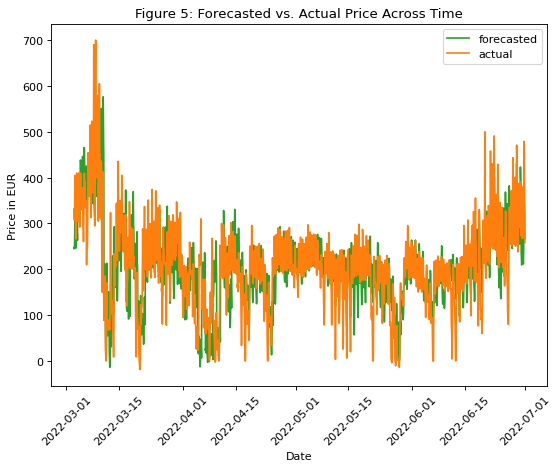

In [110]:
figure(figsize=(8, 6), dpi=80)
plt.plot(results['dt'], results['forecasted'], label='forecasted', color='#2ca02c')
plt.plot(results['dt'], results['actual'], label='actual', color='#ff7f0e')
plt.xlabel('Date')
plt.ylabel('Price in EUR')
plt.legend()
plt.title("Figure 5: Forecasted vs. Actual Price Across Time")
plt.xticks(rotation = 45)
plt.show()